In [3]:
# source("scripts/ChinaHW_cluster/main.R")
Ipaper::set_dirRoot()
Ipaper::set_jupyter()

library(data.table)
library(tidyfst)
library(Ipaper)
library(purrr)
library(rtrend)
library(gg.layers)
library(tidymet)
library(sf)
library(ggplot2)
library(gg.layers)
library(rcolors)
library(patchwork)
library(changepoint)
# source("scripts/ChinaHW_cluster/main_vis.R", encoding = "UTF-8")
# source('scripts/ChinaHW_cluster/均一化分析/main_trend.R')

f_org <- "OUTPUT/ChinaHI/Trend/trend_original.rda"
f_homo <- "OUTPUT/ChinaHI/Trend/trend_homo.rda"
devtools::load_all()


[1] "/share/home/kong/github/rpkgs/RHtestsHelper"


ℹ Loading RHtestsHelper


In [9]:
f_input <- "data-raw/INPUT/INPUT_met2474_Tmax&RHmax_for_HImax_1951-2022_V2.fst"
df <- import_fst(f_input)
df_org <- df[, .(site, date, value = RH_avg)]
l_org <- df_org %>% dt_day2year()

fs <- query_fileList()
siteHomoInfo <- fread(fs$homoInfo)
sites_homo <- siteHomoInfo[homo == "Yes", site] %>% as.character() # 413个站点
siteHomoInfo[, .N, homo]


homo,N
<chr>,<int>
Yes,413
No,1199
?,528


[data.table]: 
# A data frame: 2,474 × 5
    site n_all n_miss perc_miss nyear
   <int> <int>  <int>     <dbl> <dbl>
 1 50136   744      0     0        62
 2 50137   252      0     0        21
 3 50246   744    113     0.152    62
 4 50247   588      0     0        49
 5 50349   612      0     0        51
 6 50353   744      0     0        62
 7 50425   744      0     0        62
 8 50431   744      0     0        62
 9 50434   744      0     0        62
10 50442   672      0     0        56
# ℹ 2,464 more rows


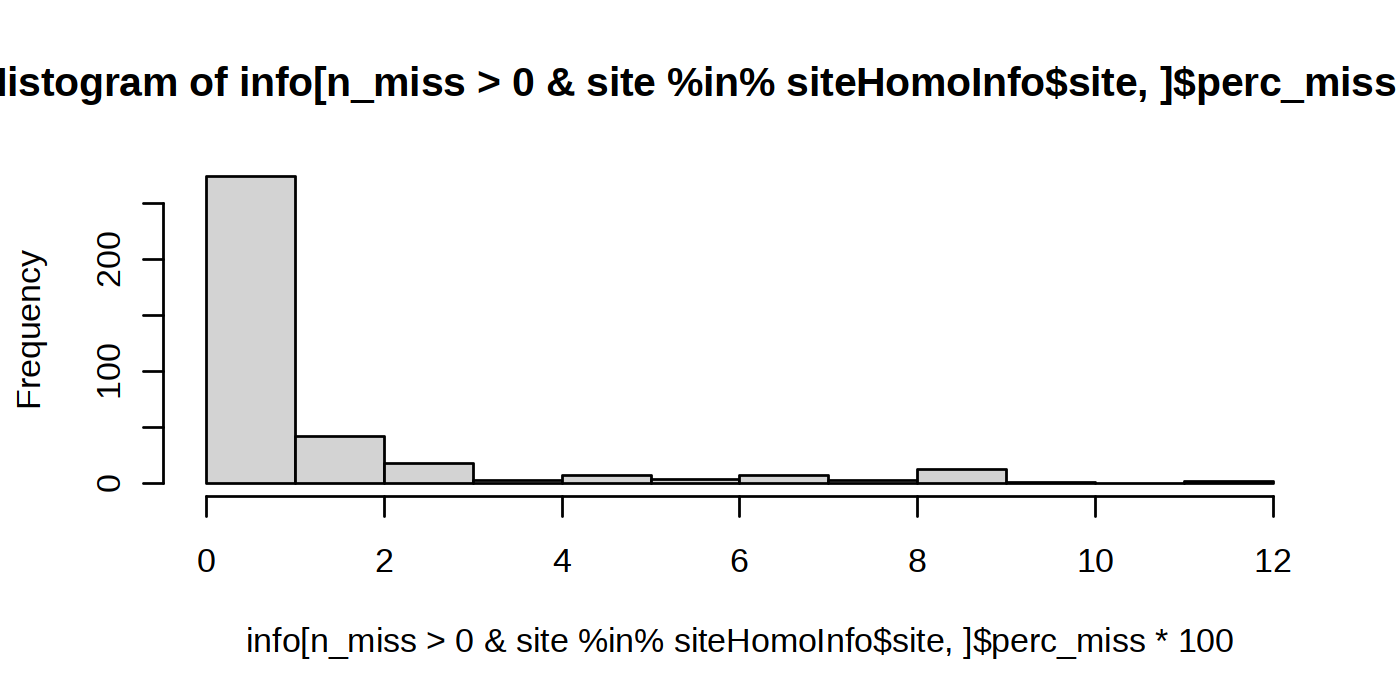

In [23]:
## monthly数据的缺失情况
Ipaper::set_jupyter(7, 3.5)

info <- l_org$mon[, .(n_all = .N, n_miss = sum(is.na(value))), .(site)] %>%
  mutate(perc_miss = n_miss / n_all, nyear = n_all / 12)
hist(info[n_miss > 0 & site %in% siteHomoInfo$site, ]$perc_miss * 100)

print(info)

## 1. 均值与方差检验

In [15]:
## 采用cpt_meanvar进行矫正
# l_org <- df_org %>% dt_day2year()
df_mon <- l_org$mon %>% interp_hisavg_month()

info_TP <- detect_TP_cpt(df_mon) # 采用monthly数据检测TP

.
   2 
1008 
[1] 55


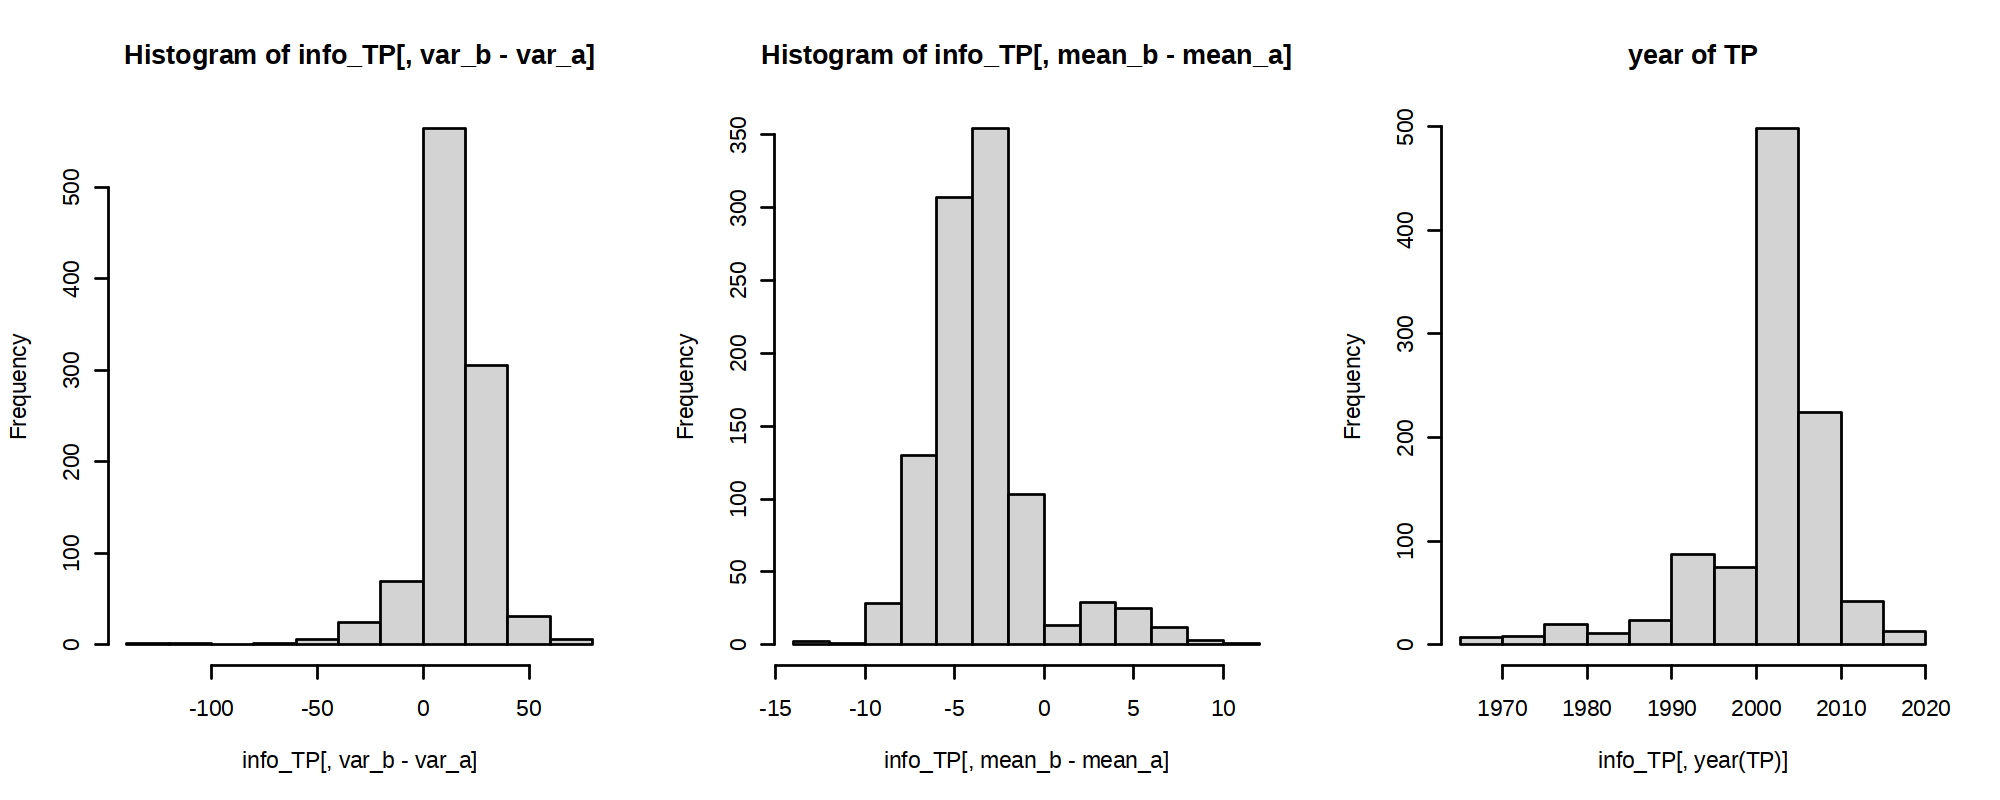

In [20]:
Ipaper::set_jupyter(10, 4)
## 突变的年份
old.par = par(mfrow = c(1, 3))
hist(info_TP[, var_b - var_a])
hist(info_TP[, mean_b - mean_a])
hist(info_TP[, year(TP)], main = "year of TP")
par(old.par)

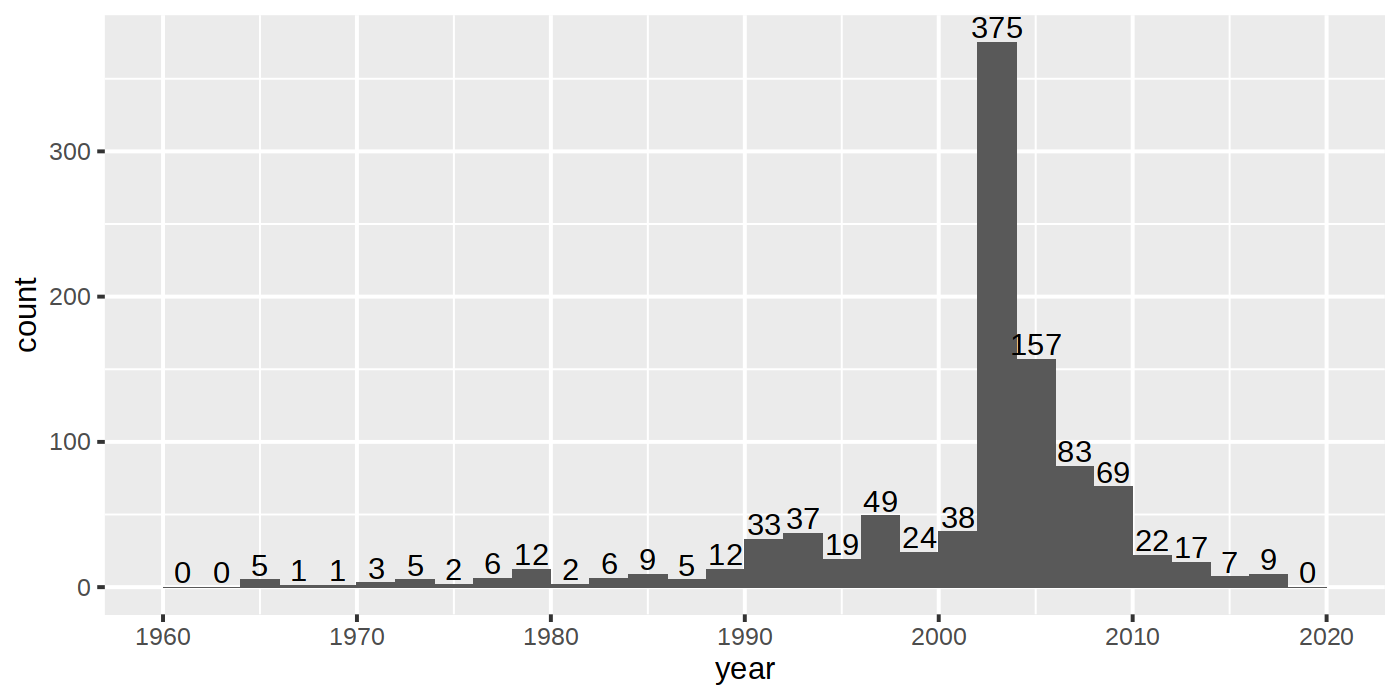

In [26]:
## 突变的年份
brks <- seq(1960, 2020, 2)
pdat = info_TP[, .(site, year = year(TP))]

p <- ggplot(pdat, aes(year)) +
  geom_histogram(breaks = brks, binwidth = 0.02) + # (a, b]
  stat_bin(aes(y = after_stat(count), label = after_stat(count)), breaks = brks, geom = "text", vjust = -0.2) +
  scale_x_continuous(breaks = seq(1960, 2020, 10))
p
# 77.98% (786 out 1008)的站点均值和方差突变发生在2000年之后。

## 1. 和metadata对比

In [30]:
info2 = merge(info_TP[, .(site, TP)], 
  st_moveInfo[, .(site, tag, moveTimes, period_date_begin, period_date_end)]) %>%
  mutate(diffdays = diffday(TP, period_date_begin)) %>% 
  .[, .SD[which.min(abs(diffdays)), ], .(site)]
print(nrow(info2))

# 检查站点迁移情况
info2[abs(diffdays) <= 3*365, ] %>% .[year(TP) <= 2000, ] %>% 
  arrange(TP) %>% 
  print(n = 100)
# 将info2保存出来


[1] 1008
[data.table]: 
# A data frame: 82 × 7
    site TP           tag moveTimes period_date_begin period_date_end diffdays
   <int> <date>     <int>     <int> <date>            <date>             <int>
 1 51886 1965-12-01     2         5 1964-06-01        1968-08-31           548
 2 56043 1966-04-01     2         4 1966-01-01        1973-12-31            90
 3 56882 1966-04-01     2         6 1964-06-01        1967-08-31           669
 4 52815 1966-06-01     2         3 1966-04-01        1973-12-31            61
 5 56096 1966-12-01     3         3 1967-01-01        2018-12-31           -31
 6 53513 1968-11-01     2         5 1966-01-01        1979-12-31          1035
 7 58222 1970-02-01     3         4 1973-01-01        2006-12-31         -1065
 8 53662 1972-02-01     2         3 1971-11-01        2017-12-31            92
 9 57345 1973-01-01     4         5 1973-01-01        1978-08-31             0
10 58530 1973-07-01     2         3 1972-01-01        1982-12-31           547
11 59

### QM矫正

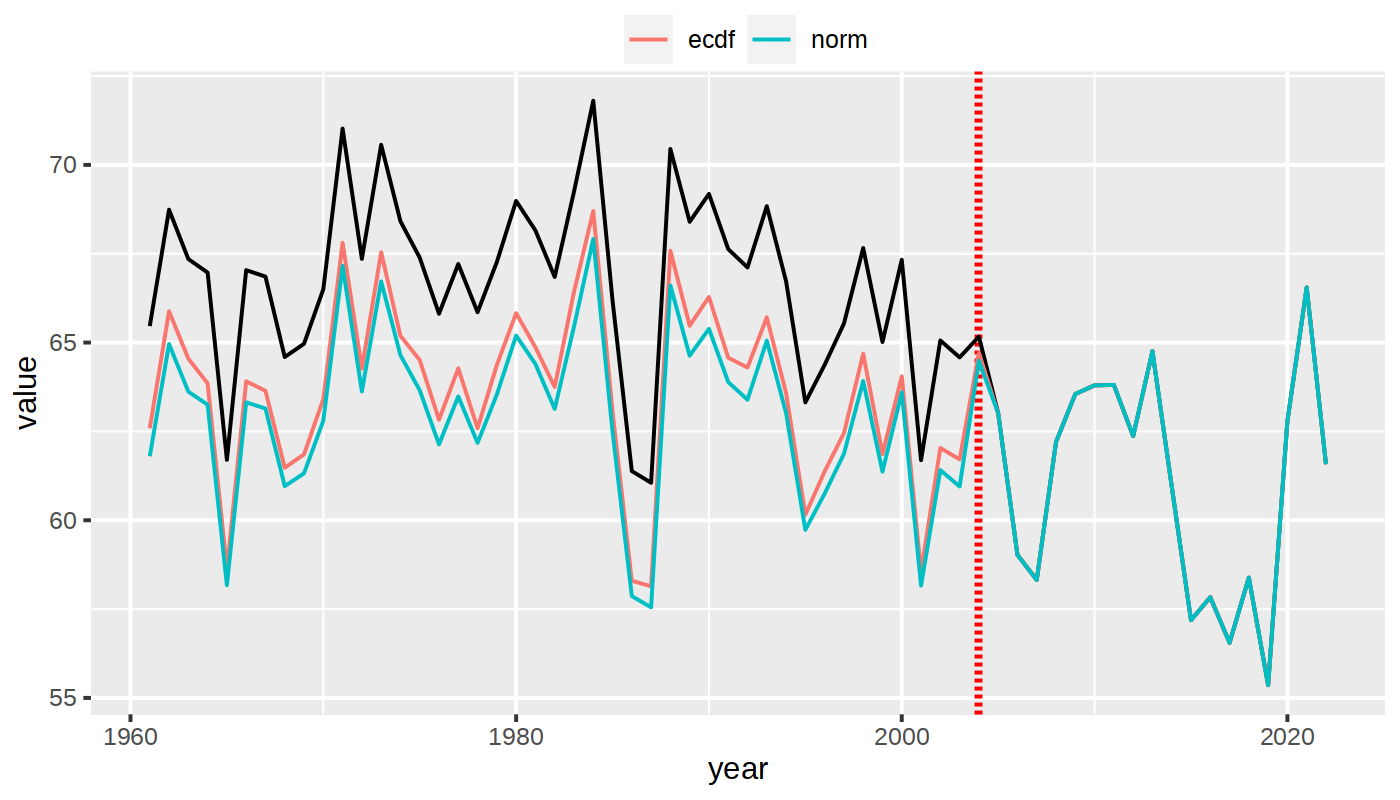

In [34]:
## 其中一个站点
Ipaper::set_jupyter(7, 4, 200)
sitename <- 50525L

date_TP <- info_TP[site == sitename, TP]
# d = df_mon[site == sitename, ]
d <- df_org[site == sitename, ]

nyear <- 5
d_adj_mon <- cpt_QM(d$value, d$date, date_TP, nyear = nyear, methods = c("ecdf", "norm")) %>%
  get_yearly()

pdat <- melt(d_adj_mon[, -2], c("year"))
p <- ggplot(pdat, aes(year, value, color = variable)) +
  geom_vline(xintercept = year(date_TP), color = "red", linetype = 2, linewidth = 1) +
  geom_line(data = d_adj_mon, aes(y = base), color = "black") +
  geom_line() + 
  labs(color = NULL) + 
  theme(
    legend.position = "top",
    legend.margin = margin(t = 0, b = -8)
  )
p


In [ ]:
## 采用cpt_meanvar进行矫正
l_org <- df_org %>% dt_day2year()
df_mon <- l_org$mon %>% interp_hisavg_month()

info_TP <- detect_TP_cpt(df_mon) # 采用monthly数据检测TP
df_adj <- homo_cpt(df_org, info_TP, nyear = 5)

export_fst(df_adj, "OUTPUT/ChinaHI/RHtests_v20230331_RH_avg-cpt_meanvar.fst")
# 只修正了786个自动化站点

In [ ]:
get_RegionalMean <- function(df_adj) {
  d_yearly.adj = df_adj %>% get_yearly("site")
  d_region.adj = dt_mean(d_yearly.adj %>% select(-site), .(year))
  # d = d_region.adj %>% melt("year")
  d_region.adj
}

d_05 = get_RegionalMean(df_adj_05)
d_all = get_RegionalMean(df_adj_all)

dat = merge(d_05, d_all, by = c("year")) %>% melt("year")


In [ ]:
# 理想情况，摆脱极端干旱与极端湿润的年份
ggplot(dat, aes(year, value, color = variable, shape = variable)) +
  geom_point() +
  geom_line(aes(linetype = variable)) +
  ggtitle("all years")
# labs(title = "5 years")

## 2. 温度

In [4]:
## 采用cpt_meanvar进行矫正
df_org = df[, .(site, date, value = Tair_max)]
l_org <- df_org %>% dt_day2year()
df_mon <- l_org$mon %>% interp_hisavg_month()

info_TP <- detect_TP_cpt(df_mon, fun = cpt.mean) # 采用monthly数据检测TP
print(info_TP)
df_adj <- homo_cpt(df_org, info_TP, nyear = 5)
# 只修正了786个自动化站点

## 对温度的影响


ERROR: Error in df[, .(site, date, value = Tair_max)]: object of type 'closure' is not subsettable
